In [ ]:
![ -e 'zip.train' ] || ( wget https://web.stanford.edu/~hastie/ElemStatLearn/datasets/zip.train.gz && gzip -d zip.train.gz )
![ -e 'zip.test' ] || ( wget https://web.stanford.edu/~hastie/ElemStatLearn/datasets/zip.test.gz && gzip -d zip.test.gz )

--2021-01-25 05:04:00--  https://web.stanford.edu/~hastie/ElemStatLearn/datasets/zip.train.gz
Resolving web.stanford.edu (web.stanford.edu)... 171.67.215.200, 2607:f6d0:0:925a::ab43:d7c8
Connecting to web.stanford.edu (web.stanford.edu)|171.67.215.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1829071 (1.7M) [application/x-gzip]
Saving to: ‘zip.train.gz’

zip.train.gz        100%[===================>]   1.74M   573KB/s    in 3.2s    

2021-01-25 05:04:04 (553 KB/s) - ‘zip.train.gz’ saved [1829071/1829071]

--2021-01-25 05:04:04--  https://web.stanford.edu/~hastie/ElemStatLearn/datasets/zip.test.gz
Resolving web.stanford.edu (web.stanford.edu)... 171.67.215.200, 2607:f6d0:0:925a::ab43:d7c8
Connecting to web.stanford.edu (web.stanford.edu)|171.67.215.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 439208 (429K) [application/x-gzip]
Saving to: ‘zip.test.gz’

zip.test.gz         100%[===================>] 428.91K   696KB/s    in 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
class Classifier:
    
    def accuracy(self, labels, predictions):
        return np.mean(np.all(labels == predictions, axis=1))

In [ ]:
training_data_zip = np.array(pd.read_csv('zip.train', sep=' ', header=None))
test_data_zip = np.array(pd.read_csv('zip.test', sep =' ',header=None))

X_zip_train, y_zip_train = training_data_zip[:,1:-1], training_data_zip[:,0]
X_zip_test, y_zip_test = test_data_zip[:,1:], test_data_zip[:,0]

In [ ]:
def encode_target(y):
    return np.array([y == i for i in range(10)]).T

In [ ]:
y_zip_train_encoded = encode_target(y_zip_train)
y_zip_test_encoded = encode_target(y_zip_test)

In [ ]:
class MultilayerPerceptronClassifier(Classifier):
    def __init__(self, hidden_neurons_numbers, max_iters=100, learning_rate=0.8):
        self.hidden_neurons_numbers = tuple(hidden_neurons_numbers)
        self.max_iters = max_iters
        self.learning_rate = learning_rate
        
    def fit(self, X, Y):
        if len(Y.shape) < 2:
            Y = Y.reshape(-1, 1)
        X = np.hstack([X, np.ones((X.shape[0], 1))])
        neuron_numbers = (X.shape[1],) + tuple(i + 1 for i in self.hidden_neurons_numbers) + (Y.shape[1],)
        self.weights = [(np.random.rand(neuron_numbers[i], neuron_numbers[i + 1]) - .5) for i in range(len(neuron_numbers) - 1)]
        for w in self.weights[:-1]:
            w[:, -1].fill(0)
            w[-1, -1] = 1
            
        for it in range(self.max_iters):
            updates = [np.zeros_like(w) for w in self.weights]
            for x, y in zip(X, Y):
                x = x.reshape(-1, 1)
                hidden_values = []
                hidden_derivatives = []
                in_vals = x
                for layer in range(len(self.hidden_neurons_numbers) + 1):
                    out_vals = 1.0 / (1.0 + np.exp(-self.weights[layer].T @ in_vals))
                    np.nan_to_num(out_vals, False, 0.0, 1.0, -1.0)
                    hidden_values.append(out_vals)
                    hidden_derivatives.append(out_vals * (1.0 - out_vals))
                    in_vals = out_vals
                y_pred = in_vals
                dE = y_pred - y.reshape(-1, 1)
                E = dE ** 2 / 2.0
                deltas = [None] * len(self.hidden_neurons_numbers)
                deltas.append(hidden_derivatives[-1] * dE)
                for i in range(len(deltas) - 2, -1, -1):
                    deltas[i] = np.diag(hidden_derivatives[i].flatten()) @ self.weights[i + 1] @ deltas[i + 1]
                for i in range(len(deltas)):
                    updates[i] -= self.learning_rate * (hidden_values[i - 1] if i else x) @ deltas[i].T * (dE.T @ dE)
            for i in range(len(self.weights)):
                updates[i] /= X.shape[0]
                if i != len(self.weights) - 1:
                    updates[i][:, -1].fill(0)
                self.weights[i] += updates[i]
    
    def predict_proba(self, X):
        X = np.hstack([X, np.ones((X.shape[0], 1))])
        Y = []
        for x in X:
            for w in self.weights:
                x = 1.0 / (1.0 + np.exp(-w.T @ x))
                np.nan_to_num(x, False, 0.0, 1.0, -1.0)
            Y.append(x)
        return np.array(Y)
    
    def predict(self, X):
        return np.round(self.predict_proba(X))


In [ ]:
%%time
models = {}
losses_train = {}
losses_test = {}
for n_layers in range(1, 4):
    for n_neurons in range(8, 25, 4):
        models[(n_layers, n_neurons)] = MultilayerPerceptronClassifier((n_neurons,) * n_layers, max_iters=1200, learning_rate=0.9)
        print(f'{n_layers} layers, {n_neurons} neurons:')
        %time models[(n_layers, n_neurons)].fit(X_zip_train[:128], y_zip_test_encoded[:128])
        acc = models[(n_layers, n_neurons)].accuracy(y_zip_train_encoded[:128], models[(n_layers, n_neurons)].predict(X_zip_train[:128]))
        print('Train accuracy:', acc)
        losses_train[(n_layers, n_neurons)] = 1 - acc
        acc = models[(n_layers, n_neurons)].accuracy(y_zip_test_encoded[:128], models[(n_layers, n_neurons)].predict(X_zip_test[:128]))
        print('Test accuracy:', acc)
        losses_test[(n_layers, n_neurons)] = 1 - acc
        print()

1 layers, 8 neurons:
CPU times: user 22.6 s, sys: 11 ms, total: 22.6 s
Wall time: 22.7 s
Train accuracy: 0.0390625
Test accuracy: 0.015625

1 layers, 12 neurons:
CPU times: user 23.2 s, sys: 5.98 ms, total: 23.2 s
Wall time: 23.3 s
Train accuracy: 0.046875
Test accuracy: 0.078125

1 layers, 16 neurons:
CPU times: user 24.1 s, sys: 3.99 ms, total: 24.1 s
Wall time: 24.1 s
Train accuracy: 0.046875
Test accuracy: 0.0546875

1 layers, 20 neurons:
CPU times: user 25.2 s, sys: 5.99 ms, total: 25.2 s
Wall time: 25.2 s
Train accuracy: 0.0546875
Test accuracy: 0.0234375

1 layers, 24 neurons:
CPU times: user 29.2 s, sys: 2.97 ms, total: 29.2 s
Wall time: 29.4 s
Train accuracy: 0.0625
Test accuracy: 0.0625

2 layers, 8 neurons:
CPU times: user 32.3 s, sys: 8.02 ms, total: 32.3 s
Wall time: 32.3 s
Train accuracy: 0.0
Test accuracy: 0.0

2 layers, 12 neurons:
CPU times: user 33.8 s, sys: 10 ms, total: 33.8 s
Wall time: 33.9 s
Train accuracy: 0.0
Test accuracy: 0.0078125

2 layers, 16 neurons:
CPU 

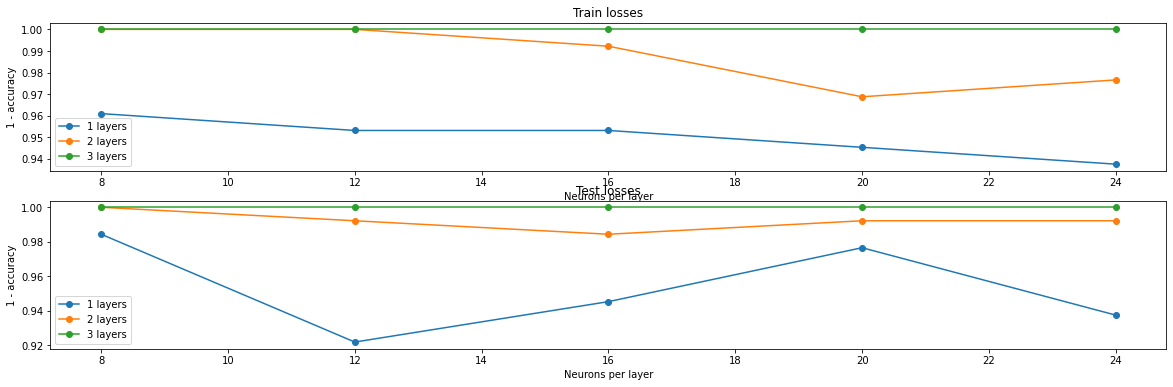

In [ ]:
plt.figure(figsize=(20, 6))
plt.subplot(2, 1, 1)
plt.title('Train losses')
for i, n_layers in enumerate(range(1, 4)):
    plt.plot(*zip(*((k[1], losses_train[k]) for k in losses_train if k[0] == n_layers)), '-o', label=f'{n_layers} layers')
plt.xlabel('Neurons per layer')
plt.ylabel('1 - accuracy')
plt.axis(True)
plt.legend()
plt.subplot(2, 1, 2)
plt.title('Test losses')
for i, n_layers in enumerate(range(1, 4)):
    plt.plot(*zip(*((k[1], losses_test[k]) for k in losses_train if k[0] == n_layers)), '-o', label=f'{n_layers} layers')
plt.legend()
plt.xlabel('Neurons per layer')
plt.ylabel('1 - accuracy')
plt.axis(True)
plt.show()

In [ ]:
%%time
np.random.seed(42)
model = MultilayerPerceptronClassifier((12,) * 1, max_iters=1200, learning_rate=0.9)
model.fit(X_zip_train, y_zip_train_encoded)
print('Train accuracy:', model.accuracy(y_zip_train_encoded, model.predict(X_zip_train)))
print('Test accuracy:', model.accuracy(y_zip_test_encoded, model.predict(X_zip_test)))

Train accuracy: 0.7690303113427513
Test accuracy: 0.7085201793721974
CPU times: user 22min 11s, sys: 289 ms, total: 22min 11s
Wall time: 22min 14s


In [ ]:
incorrect_digits = X_zip_test[np.any(y_zip_test_encoded != model.predict(X_zip_test), axis=1)][:16]

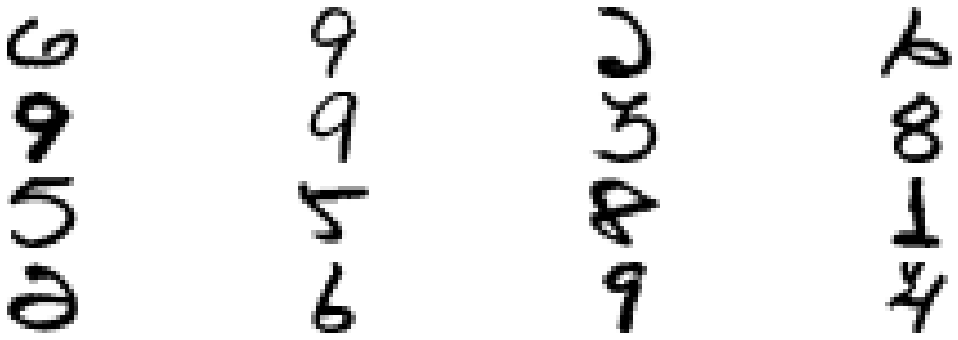

In [ ]:
plt.figure(figsize=(20, 6))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(1 - incorrect_digits[i].reshape((16, 16)), cmap='gray')
    plt.axis(False)
plt.show()

Text(0, 0.5, 'First layer')

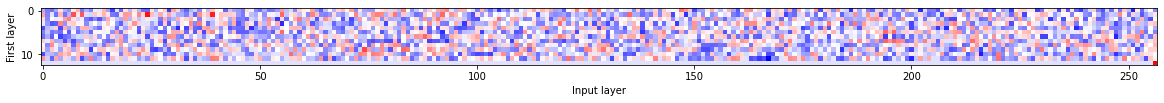

In [ ]:
plt.figure(figsize=(20, 6))
plt.imshow(model.weights[0].T, cmap='bwr')
plt.xlabel('Input layer')
plt.ylabel('First layer')